# Biosensor Characterization

In the existing literature on characterization of biosensors, the useful range of a sensor is characterized by estimating its so called linear range.  This is a region that can be roughly estimated by a line and is not usually rigoursly determined in the biosensor literature. In order for these biochemical tools to be broadly useful, we provide an approach to characterizing them that is more compatable with traditional engineering disciplines. 

In experimental practice we typically want to know how close together two measurements can be and still be distinguished. We characterize the useful range of these sensors by estimating the resolution of a sensor given the expected measurement noise $\epsilon$ and the number of replicates $n$ over the full range of possible concentrations.  This analysis is performed in two steps.  First, the sensor is characerized by using experimental data to fit a probabilistic hill function model. Then given the fit model and a set of fluorescence measurements, the distribution of compatable inducer concentrations is determined using a markov chain monte carlo aproach. 

### 1. Setup & Loading Data

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from biosensor import biosensor, distribution_range_plot,detection_range
from biosensor import hill_inverse,hill_params
from IPython.display import display
from scipy.optimize import minimize,differential_evolution

reporter='GcdR'

In this notebook, this method is demonstrated in practice.  First, characterization data is loaded for a novel gluterate biosensor.

In [2]:
def load_biosensor_data(file,sheet):
    df=pd.read_excel(file,sheetname=sheet)
    
    #Normalize RFP
    df['Norm_RFP'] = df['RFP']/df['OD600']
    
    state=True
    for x in df.Reporter.unique():
        if state==True:
            df_return = df[df.Reporter==x]
            background = df_return[df_return.Conc==0].Norm_RFP.mean()
            df_return['zeroed_rfp'] = df_return['Norm_RFP'] - background
            state=False
        else:
            df_temp = df[df.Reporter==x]
            background = df_temp[df_temp.Conc==0].Norm_RFP.mean()
            df_temp['zeroed_rfp'] = df_temp['Norm_RFP'] - background
            df_return=pd.concat([df_return,df_temp])
    
    return df_return

In [3]:
#Load Data
df = load_biosensor_data('data/example_data.xlsx','Sheet1')

/usr/local/lib/python3.6/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
#Put Cocentration and Fluorescence data into variables for downstream use
X = df.loc[df['Reporter']==reporter]['Conc'].values
Y = df.loc[df['Reporter']==reporter]['zeroed_rfp'].values

### 2. Fitting A Probabilistic Model for Biosensor Characterization

Here we are creating a model relating inducer concentrations $C$ and fluorescence measurements $F$ given data that characterizes the performance of a biosensor.  We start with a collected data set $\mathcal{D}$ charactarizing this relationship composed of a set of $N$ tuples $\mathcal{D} = \{(c_i,f_i)\}_{i=1}^N$. This relationship is modeled under the following assumptions: 

- The Relationship between analyte concentrations and flourescence can be well modeled using the hill function.
- fluorescence measurements at a particular concentration are normally distrubuted.
- The variance of flourescence measurements is roughly constant over the range of measured values.

Under these assumptions we can phrase the following probabilistic model:

$P(F|C,\theta,\alpha) = \mathcal{N}(h_\theta(C),\sigma) $

where $h_\theta(.)$ is the hill function, $\theta$ are the parameters of the hill function, and $\sigma$ is the estimated standard deviation. Using the probabilistic model which captures our constraints on the problem the log likelihood function is expressed as

$\ell(\theta,\sigma|\mathcal{D}) = \sum\limits_{i=1}^N \log P(F=f_i|C=c_i,\sigma,\theta)$.

the log likelihood is used to express the maximum liklihood estimation problem,

$\hat{\theta},\hat{\sigma} = \arg\max\limits_{\theta,\sigma} \ell(\theta,\sigma|\mathcal{D})$,

which when solved results in the optimal parameters of the model given the characterization data. 

In this notebook the biosensor model is fit by instantiating it with initial data.  During the instantiation process The maximum likelihood problem above is solved and the optimal parameters are saved in the biosensor object called ```bioS``` below. the optimal parameters after the fit can be printed using the method ```report_params()```.

In [6]:
#Fit Biosensor
bioS = biosensor(X,Y)
bioS.report_params()

,Sigma,Hill Coefficient,Max Output,Kd
0,71.185532,1.33197,5347.771783,0.317739


By bootstrapping the fit we can get error estimates

In [7]:
bioS.fit_with_error()

Sampling 2 chains: 100%|██████████| 7000/7000 [00:34<00:00, 205.18draws/s]


sigma mu: 72.7159921249 sigma: 5.46702061566
hill_coef mu: 1.33237027053 sigma: 0.0261429354011
Vmax mu: 5347.855445 sigma: 37.9482596827
Kd mu: 0.317867853132 sigma: 0.00645765668556


Then the instantiated model fit can be examined.  First we can look to see how well the model fits the data using the command below.

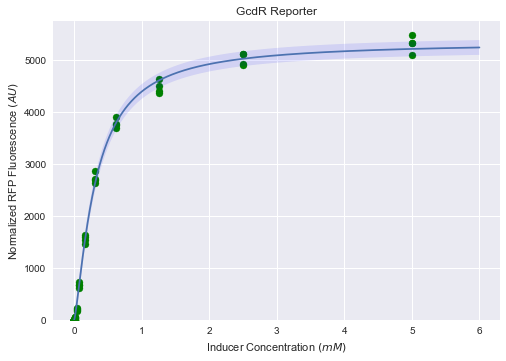

In [8]:
bioS.plot_fit()
plt.title('{} Reporter'.format(reporter))
plt.ylabel('Normalized RFP Fluorescence $(AU)$')
plt.show()

If the model fit looks satisfactory given the data, it can then be used as a tool to determine the inducer concentrations given experimental fluoresence data.

### 3. Finding Inducer Concentrations Compatable with Experimental Data

MLE of the concentration $C$

$\hat{c} = \arg\max\limits_{c} \sum\limits_{i=1}^N \log P(F=f_i|C=c,\hat{\theta},\hat{\sigma})$

We can use MCMC to solve this problem resulting in something close to the true distribution of values compatable with $c$

To demonstrate this tool assume that 3 replicates of a flourescence measurement are obtained from the fit biosensor and we want to determine the inducer concentration that produced these measurements.  Suppose the measurements have a coefficient of variation of 20% with a mean value of 3,000.  The concentration prediction is obtained using the code below which solves the maximum likelihood estimation problem defined above with Markov Chain Monte Carlo. 

In [9]:
#Simulated Measurements
Ym = np.random.normal(3000,3000*0.2,3)

#Inducer Concentration Prediction
samples = bioS.predict(Ym,pdf=True,samples=10000)

Sampling 2 chains: 100%|██████████| 23000/23000 [00:15<00:00, 1491.90draws/s]


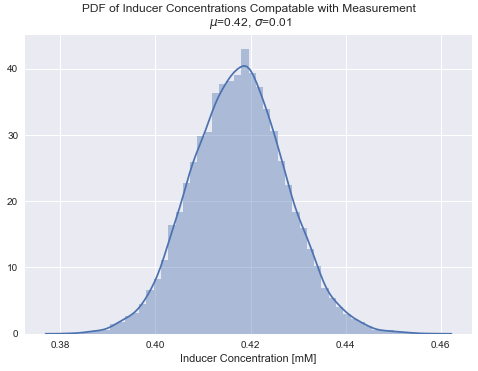

In [10]:
sns.distplot(samples)
sns.despine(top=True,right=True)
plt.title('PDF of Inducer Concentrations Compatable with Measurement\n $\mu$={:0.2f}, $\sigma$={:0.2f}'.format(np.mean(samples),np.std(samples)))
plt.xlabel('Inducer Concentration [mM]')
plt.show()

### 4. Determining the Biosensor Resolution

By solving the maximum likelihood estimation problem in section 3 iteratively over the range of observed fluorescences during the biosensor characterization process we can determine the relationship between an inducer concentration estimate and the estimates standard deviation.  the standard deviation of the estimate of inducer concentration can be interpreted as the resolution.  In the case of this work, 2 standard deviations is considered the resoultion of the sensor, as 95% of the compatable inducer concentration estimates fall within the interval $\mu \pm 2\sigma$.

Then if the fit is satisfactory we can look to see the resolution of the biosensor over the range of interest.  This function can take a fair amount of time to run as it computes montycarlo estimates for a number of predicted measurments.

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

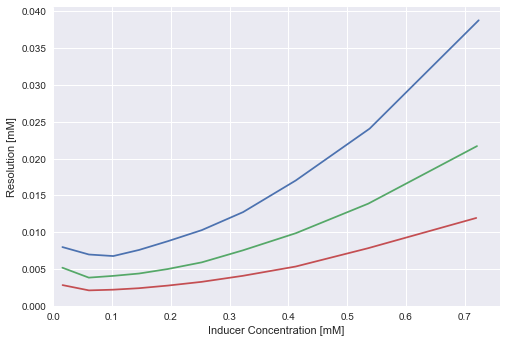

In [11]:
plt.figure()
bioS.plot_resolution(np.linspace(100,4000,10),n=1,sigma=0)
bioS.plot_resolution(np.linspace(100,4000,10),n=3,sigma=0)
bioS.plot_resolution(np.linspace(100,4000,10),n=10,sigma=0)

plt.xlabel('Inducer Concentration [mM]')
plt.ylabel('Resolution [mM]')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

### 5. Reproduction of Figure 5

Here we are contrasting the performance of two biosensors, the native biosensor, and the engineered J23101. First they must be defined.

In [18]:
#We need to create both the native gcdR and J23113 biosensor fits
gcdr_biosensor = biosensor(df.loc[df['Reporter']=='GcdR']['Conc'],df.loc[df['Reporter']=='GcdR']['zeroed_rfp'])
J23101_biosensor = biosensor(df.loc[df['Reporter']=='J101']['Conc'],df.loc[df['Reporter']=='J101']['zeroed_rfp'])

Sampling 2 chains: 100%|██████████| 43000/43000 [00:32<00:00, 1330.30draws/s]


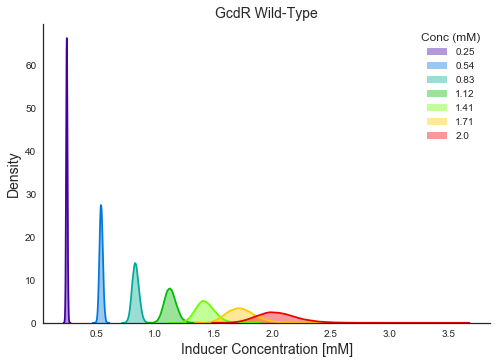

In [19]:
#Figure 5a
sns.set_style('white')
distribution_range_plot(gcdr_biosensor,np.linspace(0.25,2,7))
sns.despine(top=True,right=True)

plt.legend(['0.25','0.54','0.83','1.12','1.41','1.71','2.0'],title='Conc (mM)')


plt.title('GcdR Wild-Type',size=14)
plt.xlabel('Inducer Concentration [mM]',size=14)
plt.ylabel('Density',size=14)
plt.show()

Sampling 2 chains: 100%|██████████| 43000/43000 [00:44<00:00, 967.54draws/s] 
There were 291 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling 2 chains: 100%|██████████| 43000/43000 [00:26<00:00, 1595.93draws/s]


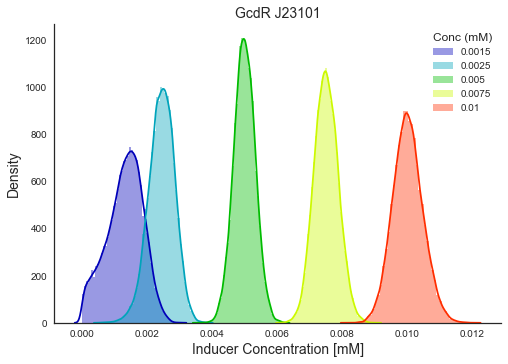

In [20]:
#Figure 5b
distribution_range_plot(J23101_biosensor,[0.0015,0.0025,0.005,0.0075, 0.01])

sns.despine(top=True,right=True)

plt.legend(['0.0015','0.0025','0.005','0.0075', '0.01'],title='Conc (mM)')


plt.title('GcdR J23101',size=14)
plt.xlabel('Inducer Concentration [mM]',size=14)
plt.ylabel('Density',size=14)

plt.show()

In [21]:
J23101_points = hill_inverse([0.0015,0.0025,0.005,0.0075, 0.01],*hill_params(J23101_biosensor))
gcdr_points = hill_inverse(np.linspace(0.01,0.3,10),*hill_params(gcdr_biosensor))



HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


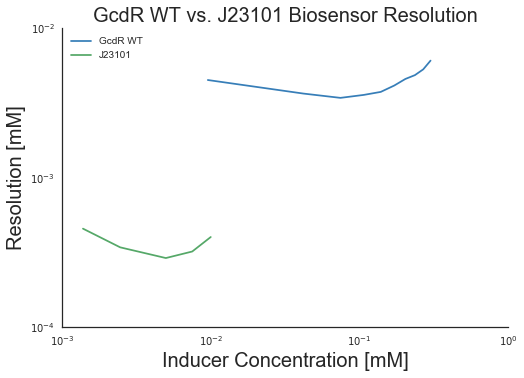

In [22]:
#Figure 5c
gcdr_biosensor.plot_resolution(gcdr_points,n=4,sigma=0)
J23101_biosensor.plot_resolution(J23101_points,n=4,sigma=0)

sns.set_style('whitegrid')
sns.despine(top=True,right=True)
sns.axes_style({'gridcolor':'1'})


plt.title('GcdR WT vs. J23101 Biosensor Resolution',size=20)
plt.xlabel('Inducer Concentration [mM]',size=20)
plt.ylabel('Resolution [mM]',size=20)

#Format Colors
for i,c in enumerate(sns.color_palette('Set1',2)):
    plt.gca().get_lines()[0].set_color(c)
plt.legend(['GcdR WT','J23101'])
plt.yscale('log')
plt.xscale('log')
plt.xlim(.001,1)
plt.ylim(.0001,.01)
plt.show()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

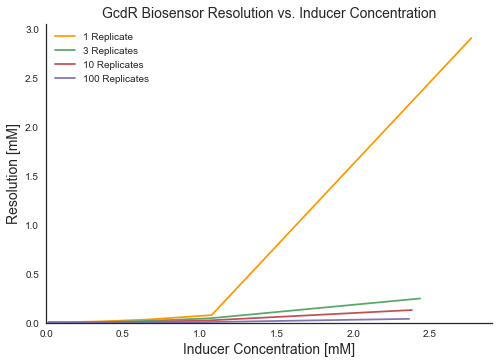

In [23]:
#Figure 5d
sns.set_style('white')
plt.figure()
gcdr_biosensor.plot_resolution(np.linspace(100,5000,10),n=1,sigma=0)
gcdr_biosensor.plot_resolution(np.linspace(100,5000,10),n=3,sigma=0)
gcdr_biosensor.plot_resolution(np.linspace(100,5000,10),n=10,sigma=0)
gcdr_biosensor.plot_resolution(np.linspace(100,5000,10),n=100,sigma=0)


plt.title('GcdR Biosensor Resolution vs. Inducer Concentration',size=14)
plt.xlabel('Inducer Concentration [mM]',size=14)
plt.ylabel('Resolution [mM]',size=14)

plt.xlim(left=0)
plt.ylim(bottom=0)

#Format Colors
for i,c in enumerate(sns.color_palette('nipy_spectral',4)):
    plt.gca().get_lines()[0].set_color(c)
plt.legend(['1 Replicate','3 Replicates','10 Replicates','100 Replicates'])
sns.despine(top=True,right=True)
plt.show()